In [116]:
"""
Brain-Computer Interface MLP Classifier
For EEG signal relaxation/focus state classification
USE FREQUENCY-BASED FEATURES (Attention & Relaxation)
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
import os
import glob
import warnings
warnings.filterwarnings('ignore')
# 導入特徵提取器
from feature_extractor import EEGFeatureExtractor, load_eeg_data_with_features


In [ ]:
class Config:
    # Dataset path settings
    DATASET_PATH = "bci_dataset_113-2"
    
    # MLP model parameters
    HIDDEN_LAYERS = (64, 24, 16)  # Restored for comprehensive features
    MAX_ITER = 60       #10 ~ 60
    LEARNING_RATE = 0.001 #0.005 ~ 0.02
    ALPHA = 0.001         #0.0001 ~ 0.05
    ACTIVATION = 'relu'
    SOLVER = 'adam'
    BATCH_SIZE = 64       #32 ~ 128
    EARLY_STOPPING = True
    VALIDATION_FRACTION = 0.1
    N_ITER_NO_CHANGE = 10
    
    # Signal processing parameters
    SAMPLING_RATE = 500
    SEGMENT_LENGTH = 5    #2 ~ 6 秒
    OVERLAP_RATIO = 0.5   #0.0 ~ 0.8
    
    # Feature selection parameters
    FEATURE_SELECTION = True
    # NOTE: When using raw data, N_FEATURES_SELECT will select the top N time points from the segment.
    # The number of features is now the number of samples in a segment (SEGMENT_LENGTH * SAMPLING_RATE).
    # You may want to adjust this value or disable feature selection.
    N_FEATURES_SELECT = 15  #10 ~ 200
    
    # Other settings
    RANDOM_STATE = 42



In [118]:
#======add =======
# 加權公式特徵提取器
class WeightedEEGFeatureExtractor:
    """使用加權公式的EEG特徵提取器"""
    
    def __init__(self, sampling_rate=500):
        self.sampling_rate = sampling_rate
        
        # 定義更細緻的頻段劃分 (Hz)
        self.iter_freqs = {
            'delta': {'fmin': 0, 'fmax': 4},
            'theta': {'fmin': 4, 'fmax': 8},
            'low_alpha': {'fmin': 8, 'fmax': 10},
            'high_alpha': {'fmin': 10, 'fmax': 13},
            'low_beta': {'fmin': 13, 'fmax': 20},
            'high_beta': {'fmin': 20, 'fmax': 35},
            'low_gamma': {'fmin': 35, 'fmax': 50},
            'high_gamma': {'fmin': 50, 'fmax': 100}
        }
    
    def get_rhythm_features_fft(self, data, fs):
        """使用FFT提取頻段特徵"""
        spectral_feature = {item: [] for item in self.iter_freqs.keys()}
        data_fft = abs(np.fft.fft(data, 128))  # 使用128點FFT
        N = len(data_fft)
        data_fft = data_fft[0:int(N / 2)]
        fr = np.linspace(0, 128, int(N / 2))  # 頻率映射
        
        for i, item in enumerate(fr):
            if self.iter_freqs['delta']['fmin'] < item < self.iter_freqs['delta']['fmax']:
                spectral_feature["delta"].append(data_fft[i] ** 2)
            elif self.iter_freqs['theta']['fmin'] < item < self.iter_freqs['theta']['fmax']:
                spectral_feature["theta"].append(data_fft[i] ** 2)
            elif self.iter_freqs['low_alpha']['fmin'] < item < self.iter_freqs['low_alpha']['fmax']:
                spectral_feature["low_alpha"].append(data_fft[i] ** 2)
            elif self.iter_freqs['high_alpha']['fmin'] < item < self.iter_freqs['high_alpha']['fmax']:
                spectral_feature["high_alpha"].append(data_fft[i] ** 2)
            elif self.iter_freqs['low_beta']['fmin'] < item < self.iter_freqs['low_beta']['fmax']:
                spectral_feature["low_beta"].append(data_fft[i] ** 2)
            elif self.iter_freqs['high_beta']['fmin'] < item < self.iter_freqs['high_beta']['fmax']:
                spectral_feature["high_beta"].append(data_fft[i] ** 2)
            elif self.iter_freqs['low_gamma']['fmin'] < item < self.iter_freqs['low_gamma']['fmax']:
                spectral_feature["low_gamma"].append(data_fft[i] ** 2)
            elif self.iter_freqs['high_gamma']['fmin'] < item < self.iter_freqs['high_gamma']['fmax']:
                spectral_feature["high_gamma"].append(data_fft[i] ** 2)
        
        # 計算各頻段的平均功率
        out = {}
        for key, value in spectral_feature.items():
            out[key] = np.mean(value) if value else 0.0
        return out
    
    def get_attention_score(self, features):
        """
        獲得當前幀的瞬時專注度
        使用加權公式: attn_score = w_1 * avg_beta / (w_2 * avg_alpha + w_3 * avg_theta)
        """
        weight = [2, 1, 1]
        # 計算平均beta波 (low_beta + high_beta) / 2
        avg_beta = (features["low_beta"] + features['high_beta']) / 2
        # 計算平均alpha波 (low_alpha + high_alpha) / 2  
        avg_alpha = (features["low_alpha"] + features['high_alpha']) / 2
        
        # 加權專注度公式
        attention_score = (weight[0] * avg_beta) / (weight[1] * avg_alpha + weight[2] * features["theta"])
        return attention_score
    
    def get_meditation_score(self, features):
        """
        獲得當前幀的瞬時放鬆度
        使用公式: medit_score = avg_alpha / (avg_alpha + avg_theta + avg_beta)
        """
        # 計算平均alpha波
        avg_alpha = (features["low_alpha"] + features['high_alpha']) / 2
        # 計算平均beta波
        avg_beta = (features["low_beta"] + features['high_beta']) / 2
        
        # 放鬆度公式
        meditation_score = avg_alpha / (avg_alpha + features["theta"] + avg_beta)
        return meditation_score
    
    def extract_weighted_features(self, signal):
        """提取加權特徵"""
        try:
            # 使用FFT提取頻段特徵
            features = self.get_rhythm_features_fft(signal, self.sampling_rate)
            
            # 計算專注度和放鬆度
            attention = self.get_attention_score(features)
            meditation = self.get_meditation_score(features)
            
            # 組合所有特徵
            weighted_features = {
                'weighted_attention': attention,
                'weighted_meditation': meditation,
                'delta_power': features['delta'],
                'theta_power': features['theta'],
                'low_alpha_power': features['low_alpha'],
                'high_alpha_power': features['high_alpha'],
                'low_beta_power': features['low_beta'],
                'high_beta_power': features['high_beta'],
                'low_gamma_power': features['low_gamma'],
                'high_gamma_power': features['high_gamma']
            }
            
            return weighted_features
            
        except Exception as e:
            print(f"Error calculating weighted features: {e}")
            return {key: 0.0 for key in ['weighted_attention', 'weighted_meditation', 
                                        'delta_power', 'theta_power', 'low_alpha_power', 
                                        'high_alpha_power', 'low_beta_power', 'high_beta_power',
                                        'low_gamma_power', 'high_gamma_power']}

# EEG Feature Extractor Class
class EEGFeatureExtractor:
    """EEG Feature Extractor for comprehensive feature calculation"""
    
    def __init__(self, sampling_rate=500):
        self.sampling_rate = sampling_rate
        
        # Define frequency bands (Hz)
        self.freq_bands = {
            'delta': (0.5, 4),      # Delta waves
            'theta': (4, 8),        # Theta waves  
            'alpha': (8, 13),       # Alpha waves
            'beta': (13, 30),       # Beta waves
            'gamma': (30, 50)       # Gamma waves
        }
    
    def _butter_bandpass_filter(self, data, lowcut, highcut, order=4):
        """Apply Butterworth bandpass filter"""
        nyquist = 0.5 * self.sampling_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)
    
    def _calculate_band_power(self, signal, freq_band):
        """Calculate power in a specific frequency band"""
        # Apply bandpass filter
        filtered_signal = self._butter_bandpass_filter(signal, freq_band[0], freq_band[1])
        
        # Calculate power using FFT
        fft_values = fft(filtered_signal)
        power_spectrum = np.abs(fft_values) ** 2
        
        # Get frequency bins
        freqs = fftfreq(len(signal), 1/self.sampling_rate)
        
        # Find indices for the frequency band
        band_mask = (freqs >= freq_band[0]) & (freqs <= freq_band[1])
        
        # Calculate total power in the band
        band_power = np.sum(power_spectrum[band_mask])
        
        return band_power
    
    def extract_attention_feature(self, signal):
        """Calculate attention level: Ec = β / (α + θ)"""
        try:
            alpha_power = self._calculate_band_power(signal, self.freq_bands['alpha'])
            beta_power = self._calculate_band_power(signal, self.freq_bands['beta'])
            theta_power = self._calculate_band_power(signal, self.freq_bands['theta'])
            
            denominator = alpha_power + theta_power
            if denominator == 0:
                return 0.0
            return beta_power / denominator
        except Exception as e:
            print(f"Error calculating attention feature: {e}")
            return 0.0
    
    def extract_relaxation_feature(self, signal):
        """Calculate relaxation level: alphaRatio = palpha / (ptheta + palpha + pbeta)"""
        try:
            alpha_power = self._calculate_band_power(signal, self.freq_bands['alpha'])
            beta_power = self._calculate_band_power(signal, self.freq_bands['beta'])
            theta_power = self._calculate_band_power(signal, self.freq_bands['theta'])
            
            total_power = theta_power + alpha_power + beta_power
            if total_power == 0:
                return 0.0
            return alpha_power / total_power
        except Exception as e:
            print(f"Error calculating relaxation feature: {e}")
            return 0.0
    
    def extract_statistical_features(self, signal):
        """Extract statistical features from the signal"""
        try:
            features = {
                'mean': np.mean(signal),
                'std': np.std(signal),
                'var': np.var(signal),
            #    'skewness': skew(signal),
            #    'kurtosis': kurtosis(signal),
            #    'rms': np.sqrt(np.mean(signal**2)),
            #    'peak_to_peak': np.max(signal) - np.min(signal),
            #    'zero_crossing_rate': np.sum(np.diff(np.signbit(signal))),
            #    'energy': np.sum(signal**2),
            #    'power': np.mean(signal**2)
            }
            return features
        except Exception as e:
            print(f"Error calculating statistical features: {e}")
            return {key: 0.0 for key in ['mean', 'std', 'var', 'skewness', 'kurtosis', 
                                        'rms', 'peak_to_peak', 'zero_crossing_rate', 'energy', 'power']}
    
    def extract_frequency_features(self, signal):
        """Extract frequency domain features"""
        try:
            fft_values = fft(signal)
            power_spectrum = np.abs(fft_values) ** 2
            freqs = fftfreq(len(signal), 1/self.sampling_rate)
            
            # Only use positive frequencies
            positive_freqs = freqs[:len(freqs)//2]
            positive_power = power_spectrum[:len(power_spectrum)//2]
            
            # Spectral centroid
            spectral_centroid = np.sum(positive_freqs * positive_power) / np.sum(positive_power)
            
            # Spectral rolloff (95% of energy)
            cumulative_power = np.cumsum(positive_power)
            total_power = cumulative_power[-1]
            rolloff_idx = np.where(cumulative_power >= 0.95 * total_power)[0]
            spectral_rolloff = positive_freqs[rolloff_idx[0]] if len(rolloff_idx) > 0 else positive_freqs[-1]
            
            # Spectral bandwidth
            spectral_bandwidth = np.sqrt(np.sum(((positive_freqs - spectral_centroid) ** 2) * positive_power) / np.sum(positive_power))
            
            # Spectral flatness
            geometric_mean = np.exp(np.mean(np.log(positive_power + 1e-10)))
            arithmetic_mean = np.mean(positive_power)
            spectral_flatness = geometric_mean / arithmetic_mean if arithmetic_mean > 0 else 0
            
            features = {
                'spectral_centroid': spectral_centroid,
                'spectral_rolloff': spectral_rolloff,
                'spectral_bandwidth': spectral_bandwidth,
                'spectral_flatness': spectral_flatness
            }
            return features
        except Exception as e:
            print(f"Error calculating frequency features: {e}")
            return {key: 0.0 for key in ['spectral_centroid', 'spectral_rolloff', 'spectral_bandwidth', 'spectral_flatness']}
    
    def extract_band_ratios(self, signal):
        """Extract band power ratios"""
        try:
            band_powers = self.extract_band_powers(signal)
            total_power = sum(band_powers.values())
            if total_power == 0:
                return {key: 0.0 for key in ['delta_ratio', 'theta_ratio', 'alpha_ratio', 'beta_ratio', 'gamma_ratio',
                                           'beta_alpha_ratio', 'theta_alpha_ratio', 'beta_theta_ratio']}
            
            features = {
             #   'delta_ratio': band_powers['delta'] / total_power,
            #    'theta_ratio': band_powers['theta'] / total_power,
                'alpha_ratio': band_powers['alpha'] / total_power,
                'beta_ratio': band_powers['beta'] / total_power,
              #  'gamma_ratio': band_powers['gamma'] / total_power,
                'beta_alpha_ratio': band_powers['beta'] / band_powers['alpha'] if band_powers['alpha'] > 0 else 0,
             #   'theta_alpha_ratio': band_powers['theta'] / band_powers['alpha'] if band_powers['alpha'] > 0 else 0,
             #   'beta_theta_ratio': band_powers['beta'] / band_powers['theta'] if band_powers['theta'] > 0 else 0
            }
            return features
        except Exception as e:
            print(f"Error calculating band ratios: {e}")
            return {key: 0.0 for key in ['delta_ratio', 'theta_ratio', 'alpha_ratio', 'beta_ratio', 'gamma_ratio',
                                        'beta_alpha_ratio', 'theta_alpha_ratio', 'beta_theta_ratio']}
    
    def extract_band_powers(self, signal):
        """Extract power in all frequency bands"""
        band_powers = {}
        for band_name, freq_range in self.freq_bands.items():
            band_powers[band_name] = self._calculate_band_power(signal, freq_range)
        return band_powers
    
    def extract_all_features(self, signal):
        """Extract comprehensive feature set"""
        # Original attention and relaxation features
        attention = self.extract_attention_feature(signal)
        relaxation = self.extract_relaxation_feature(signal)
        
        # Statistical features
        stat_features = self.extract_statistical_features(signal)
        
        # Frequency features
        freq_features = self.extract_frequency_features(signal)
        
        # Band ratio features
        ratio_features = self.extract_band_ratios(signal)
        
        # Combine all features
        all_features = {
            'attention': attention,
            'relaxation': relaxation,
            **stat_features,
            **freq_features,
            **ratio_features
        }
        
        return all_features
#======add =======


In [119]:

# Data Loading and Processing
def load_eeg_data(subject_path):
    """Load EEG data for a single subject"""
    relax_file = os.path.join(subject_path, "1.txt")
    focus_file = os.path.join(subject_path, "2.txt")
    
    try:
        relax_data = np.loadtxt(relax_file)
        focus_data = np.loadtxt(focus_file)
        return relax_data, focus_data
    except Exception as e:
        print(f"Error loading data for {subject_path}: {e}")
        return None, None

def create_segments(data, segment_length_samples, overlap_samples):
    """Split continuous EEG signal into multiple segments"""
    if len(data) < segment_length_samples:
        return np.array([]) # Return empty array if not enough data for one segment
    
    segments = []
    start = 0
    step = segment_length_samples - overlap_samples
    
    while start + segment_length_samples <= len(data):
        segment = data[start:start + segment_length_samples]
        segments.append(segment)
        start += step
    
    return np.array(segments)




In [120]:

# Model Definition and Training
class EnhancedBCIClassifier:
    """Enhanced Brain-Computer Interface Classifier"""
    
    def __init__(self):
        self.model = MLPClassifier(
            hidden_layer_sizes=Config.HIDDEN_LAYERS,
            max_iter=Config.MAX_ITER,
            learning_rate_init=Config.LEARNING_RATE,
            alpha=Config.ALPHA,
            activation=Config.ACTIVATION,
            solver=Config.SOLVER,
            batch_size=Config.BATCH_SIZE,
            early_stopping=Config.EARLY_STOPPING,
            validation_fraction=Config.VALIDATION_FRACTION,
            n_iter_no_change=Config.N_ITER_NO_CHANGE,
            random_state=Config.RANDOM_STATE,
            verbose=False
        )
        self.scaler = StandardScaler()
        # The number of features k should be less than or equal to the number of samples in a segment
        num_features = Config.SAMPLING_RATE * Config.SEGMENT_LENGTH
        k_features = min(Config.N_FEATURES_SELECT, num_features)
        
        self.feature_selector = SelectKBest(f_classif, k=k_features) if Config.FEATURE_SELECTION else None
        
    def fit(self, X, y):
        """Train the model"""
        # Standardization
        X_scaled = self.scaler.fit_transform(X)
        
        # Feature selection
        if self.feature_selector is not None:
            X_selected = self.feature_selector.fit_transform(X_scaled, y)
        else:
            X_selected = X_scaled
        
        # Train the model
        self.model.fit(X_selected, y)
        return self
    
    def predict(self, X):
        """Make predictions"""
        X_scaled = self.scaler.transform(X)
        
        if self.feature_selector is not None:
            X_selected = self.feature_selector.transform(X_scaled)
        else:
            X_selected = X_scaled
            
        return self.model.predict(X_selected)
    
    def get_loss_curve(self):
        """Get the loss curve"""
        if hasattr(self.model, 'loss_curve_'):
            return self.model.loss_curve_
        else:
            return []


In [121]:

#======add =======
# Main Execution Functions with Comprehensive Features
def load_all_subjects():
    """Load data from all subjects"""
    extractor = EEGFeatureExtractor(Config.SAMPLING_RATE)
    all_features = []
    all_labels = []
    all_subjects = []
    
    # Find all subject folders
    subject_folders = sorted(glob.glob(os.path.join(Config.DATASET_PATH, "S*")))
    
    if not subject_folders:
        print(f"Error: No subject folders found in {Config.DATASET_PATH}")
        return None, None, None
    #======add =======
    segment_length_samples = int(Config.SEGMENT_LENGTH * Config.SAMPLING_RATE)
    #======add =======
    for subject_folder in subject_folders:
        subject_id = os.path.basename(subject_folder)
        
        # Load data
        relax_data, focus_data = load_eeg_data(subject_folder)
        
        if relax_data is None or focus_data is None:
            print(f"Error: Failed to load data for {subject_id}")
            continue
        #=====old code======
        # 
        # Create signal segments from raw data to be used as input features
        #segment_length_samples = int(Config.SEGMENT_LENGTH * Config.SAMPLING_RATE)
        #overlap_samples = int(segment_length_samples * Config.OVERLAP_RATIO)
    
        #relax_segments = create_segments(relax_data, segment_length_samples, overlap_samples)
        #focus_segments = create_segments(focus_data, segment_length_samples, overlap_samples)
        # ====old code =======
        
        # Process relax data
        relax_features = []
        for i in range(0, len(relax_data) - segment_length_samples + 1, segment_length_samples):
            segment = relax_data[i:i + segment_length_samples]
            features = extractor.extract_all_features(segment)
            # Convert to array with all features
            feature_array = [features[key] for key in sorted(features.keys())]
            relax_features.append(feature_array)
        
        # Process focus data
        focus_features = []
        for i in range(0, len(focus_data) - segment_length_samples + 1, segment_length_samples):
            segment = focus_data[i:i + segment_length_samples]
            features = extractor.extract_all_features(segment)
            # Convert to array with all features
            feature_array = [features[key] for key in sorted(features.keys())]
            focus_features.append(feature_array)
        #======add =======
           # The segments are now our "features"
       # relax_features = relax_segments
       # focus_features = focus_segments
        # Label data
        relax_labels = np.zeros(len(relax_features))  # 0 = relax
        focus_labels = np.ones(len(focus_features))   # 1 = focus
        
        # Combine data
        subject_features = np.vstack([relax_features, focus_features])
        subject_labels = np.hstack([relax_labels, focus_labels])
        
        # Record subject IDs
        subject_ids = [subject_id] * len(subject_labels)
        
        all_features.append(subject_features)
        all_labels.append(subject_labels)
        all_subjects.extend(subject_ids)
    
    if not all_features:
        print("Error: No valid data found")
        return None, None, None
    
    # Combine all data
    X = np.vstack(all_features)
    y = np.hstack(all_labels)
    #======add =======
    print(f"Total features extracted: {X.shape[0]}")
    print(f"Feature dimensions: {X.shape[1]} (comprehensive feature set)")
    
    # Print feature names
    if X.shape[0] > 0:
        sample_features = extractor.extract_all_features(np.random.randn(segment_length_samples))
        feature_names = sorted(sample_features.keys())
        print(f"Feature names: {feature_names}")
    #======add =======
    return X, y, all_subjects


In [122]:

def leave_one_subject_out_validation():
    """Perform Leave-One-Subject-Out cross-validation"""
    print("Starting Leave-One-Subject-Out Cross-Validation with RAW DATA...")
    
    # Load all data
    X, y, subjects = load_all_subjects()
    
    if X is None:
        return None
    
    # Get unique subject list
    unique_subjects = sorted(list(set(subjects)))
    
    # Store results
    results = {
        'accuracies': [],
        'confusion_matrices': [],
        'loss_curves': [],
        'subject_names': []
    }
    
    # Test each subject
    for test_subject in unique_subjects:
        # Split training and test sets
        train_mask = [s != test_subject for s in subjects]
        test_mask = [s == test_subject for s in subjects]
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        # Train model
        classifier = EnhancedBCIClassifier()
        classifier.fit(X_train, y_train)
        
        # Predict
        y_pred = classifier.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        
        # Store results
        results['accuracies'].append(accuracy)
        results['confusion_matrices'].append(cm)
        results['loss_curves'].append(classifier.get_loss_curve())
        results['subject_names'].append(test_subject)
        
        print(f"{test_subject}: Accuracy = {accuracy:.3f}")
    
    return results


In [123]:

def plot_results(results):
    """Plot result charts"""
    if results is None:
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('BCI Classifier (Raw Data) - LOSO Cross-Validation Results', fontsize=16)
    
    # 1. Accuracy distribution
    axes[0].bar(range(len(results['accuracies'])), results['accuracies'], 
                color=['green' if acc >= 0.7 else 'orange' if acc >= 0.6 else 'red' 
                       for acc in results['accuracies']])
    axes[0].set_title('Accuracy by Subject')
    axes[0].set_xlabel('Subject Index')
    axes[0].set_ylabel('Accuracy')
    axes[0].axhline(y=np.mean(results['accuracies']), color='r', linestyle='--', 
                    label=f'Mean: {np.mean(results["accuracies"]):.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)
    
    # 2. Overall confusion matrix
    total_cm = np.sum(results['confusion_matrices'], axis=0)
    sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Relax', 'Focus'],
                yticklabels=['Relax', 'Focus'],
                ax=axes[1])
    axes[1].set_title('Overall Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    # 3. Training loss curves
    valid_loss_curves = [lc for lc in results['loss_curves'] if len(lc) > 0]
    if valid_loss_curves:
        for i, loss_curve in enumerate(valid_loss_curves[:5]):  # Show first 5
            axes[2].plot(loss_curve, alpha=0.7, label=f'S{i+1}')
        axes[2].set_title('Training Loss Curves (First 5 Subjects)')
        axes[2].set_xlabel('Iteration')
        axes[2].set_ylabel('Loss')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'No loss curves available', 
                     horizontalalignment='center', verticalalignment='center',
                     transform=axes[2].transAxes)
        axes[2].set_title('Training Loss Curves')
    
    plt.tight_layout()
    #plt.savefig('bci_results_raw_data.png', dpi=300, bbox_inches='tight')
    plt.show()


In [125]:
# 使用加權公式的完整分類流程
def load_all_subjects_with_weighted_features():
    """使用加權公式載入所有受試者數據"""
    weighted_extractor = WeightedEEGFeatureExtractor(Config.SAMPLING_RATE)
    all_features = []
    all_labels = []
    all_subjects = []
    
    # 找到所有受試者資料夾
    subject_folders = sorted(glob.glob(os.path.join(Config.DATASET_PATH, "S*")))
    
    if not subject_folders:
        print(f"錯誤: 在 {Config.DATASET_PATH} 中找不到受試者資料夾")
        return None, None, None
    
    segment_length_samples = int(Config.SEGMENT_LENGTH * Config.SAMPLING_RATE)
    
    for subject_folder in subject_folders:
        subject_id = os.path.basename(subject_folder)
        
        # 載入數據
        relax_data, focus_data = load_eeg_data(subject_folder)
        
        if relax_data is None or focus_data is None:
            print(f"錯誤: 無法載入 {subject_id} 的數據")
            continue
        
        # 處理放鬆數據
        relax_features = []
        for i in range(0, len(relax_data) - segment_length_samples + 1, segment_length_samples):
            segment = relax_data[i:i + segment_length_samples]
            features = weighted_extractor.extract_weighted_features(segment)
            # 轉換為陣列格式
            feature_array = [features[key] for key in sorted(features.keys())]
            relax_features.append(feature_array)
        
        # 處理專注數據
        focus_features = []
        for i in range(0, len(focus_data) - segment_length_samples + 1, segment_length_samples):
            segment = focus_data[i:i + segment_length_samples]
            features = weighted_extractor.extract_weighted_features(segment)
            # 轉換為陣列格式
            feature_array = [features[key] for key in sorted(features.keys())]
            focus_features.append(feature_array)
        
        if not relax_features or not focus_features:
            print(f"警告: {subject_id} 沒有足夠的數據來創建片段。跳過此受試者。")
            continue
        
        # 標記數據
        relax_labels = np.zeros(len(relax_features))  # 0 = 放鬆
        focus_labels = np.ones(len(focus_features))   # 1 = 專注
        
        # 合併數據
        subject_features = np.vstack([relax_features, focus_features])
        subject_labels = np.hstack([relax_labels, focus_labels])
        
        # 記錄受試者ID
        subject_ids = [subject_id] * len(subject_labels)
        
        all_features.append(subject_features)
        all_labels.append(subject_labels)
        all_subjects.extend(subject_ids)
    
    if not all_features:
        print("錯誤: 找不到有效數據")
        return None, None, None
    
    # 合併所有數據
    X = np.vstack(all_features)
    y = np.hstack(all_labels)
    
    print(f"使用加權公式提取的特徵總數: {X.shape[0]}")
    print(f"特徵維度: {X.shape[1]} (加權特徵集)")
    
    # 顯示特徵名稱
    if X.shape[0] > 0:
        sample_features = weighted_extractor.extract_weighted_features(np.random.randn(segment_length_samples))
        feature_names = sorted(sample_features.keys())
        print(f"特徵名稱: {feature_names}")
    
    return X, y, all_subjects

def leave_one_subject_out_validation_weighted():
    """使用加權公式進行留一受試者交叉驗證"""
    print("開始使用加權公式進行留一受試者交叉驗證...")
    
    # 載入所有數據
    X, y, subjects = load_all_subjects_with_weighted_features()
    
    if X is None:
        return None
    
    # 獲取唯一受試者列表
    unique_subjects = sorted(list(set(subjects)))
    
    # 儲存結果
    results = {
        'accuracies': [],
        'confusion_matrices': [],
        'loss_curves': [],
        'subject_names': []
    }
    
    # 測試每個受試者
    for test_subject in unique_subjects:
        # 分割訓練和測試集
        train_mask = [s != test_subject for s in subjects]
        test_mask = [s == test_subject for s in subjects]
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        # 訓練模型
        classifier = EnhancedBCIClassifier()
        classifier.fit(X_train, y_train)
        
        # 預測
        y_pred = classifier.predict(X_test)
        
        # 計算準確率
        accuracy = accuracy_score(y_test, y_pred)
        
        # 混淆矩陣
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        
        # 儲存結果
        results['accuracies'].append(accuracy)
        results['confusion_matrices'].append(cm)
        results['loss_curves'].append(classifier.get_loss_curve())
        results['subject_names'].append(test_subject)
        
        print(f"{test_subject}: 準確率 = {accuracy:.3f}")
    
    return results


BCI EEG Classification (Raw Data Input) - Relaxation vs Concentration
Starting Leave-One-Subject-Out Cross-Validation with RAW DATA...
Total features extracted: 2933
Feature dimensions: 12 (comprehensive feature set)
Feature names: ['alpha_ratio', 'attention', 'beta_alpha_ratio', 'beta_ratio', 'mean', 'relaxation', 'spectral_bandwidth', 'spectral_centroid', 'spectral_flatness', 'spectral_rolloff', 'std', 'var']
S01: Accuracy = 0.660
S02: Accuracy = 0.506
S03: Accuracy = 0.401
S04: Accuracy = 0.734
S05: Accuracy = 0.623
S06: Accuracy = 0.856
S07: Accuracy = 0.750
S08: Accuracy = 0.642
S09: Accuracy = 0.648
S10: Accuracy = 0.531
S11: Accuracy = 0.586
S12: Accuracy = 0.537
S13: Accuracy = 0.642
S14: Accuracy = 0.556
S15: Accuracy = 0.550
S16: Accuracy = 0.608
S17: Accuracy = 0.469
S18: Accuracy = 0.525

Overall Mean Accuracy: 0.601 ± 0.106

Relax Class:
  - Accuracy (Recall): 0.652 (957/1467)
  - Precision: 0.593 (957/1615)

Concentration Class:
  - Accuracy (Recall): 0.551 (808/1466)
  -

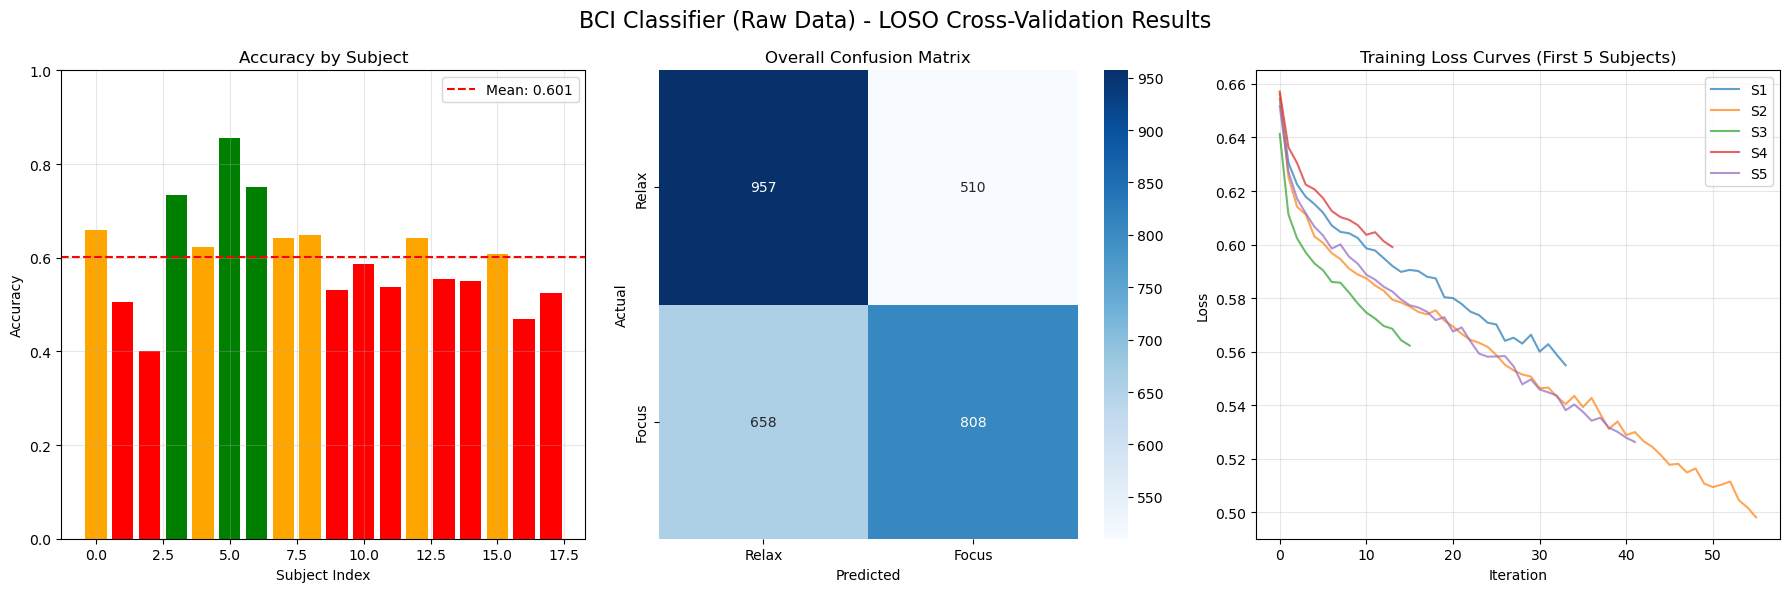


Results saved to 'bci_results_raw_data.png'


In [128]:


print("BCI EEG Classification (Raw Data Input) - Relaxation vs Concentration")
print("=" * 60)

# Perform Leave-One-Subject-Out validation
results = leave_one_subject_out_validation()

if results is None:
    print("Validation failed!")

# Display overall results
mean_accuracy = np.mean(results['accuracies'])
std_accuracy = np.std(results['accuracies'])

print(f"\nOverall Mean Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")

# Calculate and display accuracy for each class
total_cm = np.sum(results['confusion_matrices'], axis=0)

with np.errstate(divide='ignore', invalid='ignore'):
    # Calculate accuracy (Recall) for each class
    relax_accuracy = total_cm[0, 0] / np.sum(total_cm[0, :]) if np.sum(total_cm[0, :]) > 0 else 0
    concentration_accuracy = total_cm[1, 1] / np.sum(total_cm[1, :]) if np.sum(total_cm[1, :]) > 0 else 0
    
    # Calculate precision for each class
    relax_precision = total_cm[0, 0] / np.sum(total_cm[:, 0]) if np.sum(total_cm[:, 0]) > 0 else 0
    concentration_precision = total_cm[1, 1] / np.sum(total_cm[:, 1]) if np.sum(total_cm[:, 1]) > 0 else 0

print(f"\nRelax Class:")
print(f"  - Accuracy (Recall): {relax_accuracy:.3f} ({total_cm[0, 0]}/{np.sum(total_cm[0, :])})")
print(f"  - Precision: {relax_precision:.3f} ({total_cm[0, 0]}/{np.sum(total_cm[:, 0])})")

print(f"\nConcentration Class:")
print(f"  - Accuracy (Recall): {concentration_accuracy:.3f} ({total_cm[1, 1]}/{np.sum(total_cm[1, :])})")
print(f"  - Precision: {concentration_precision:.3f} ({total_cm[1, 1]}/{np.sum(total_cm[:, 1])})")

# Plot results
plot_results(results)

print(f"\nResults saved to 'bci_results_raw_data.png'")


In [129]:
print(f"\nOverall Mean Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")


Overall Mean Accuracy: 0.601 ± 0.106
